# Summar Statistics of the Books and Review Datasets

The code in this notebook provides the input for Section 3 of the JCLS 2024 paper.

Datasets:
- `book_metadata`: book metadata for 454,592 book identifiers (125,542 distinct works)
- `epub_metadata`: library catalogue records for 18,885 E-pubs from the National Library of the Netherlands
- `reviews`: review data for 670,924 reviews from seven different platforms
- `impact_matches`: reading impact matches extracted from the reviews, using the Dutch Reading Impact Model

Steps:
- link the `book_metadata` to the `epub_metadata` to add genre information to the E-pubs.
- link the `book_metadata` to the `reviews` to add book information to reviews.
- link the `epub_metadata` to the `reviews` via the `book_metadata` to link the full-text of E-pubs to their associated reviews.

In [3]:
import pandas as pd
from pathlib import Path
import gzip
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from impfic_core.map.map_genre import read_genre_file

In [11]:
impact_file = '../data/impact_matches/review-impact_matches.tsv.gz'
book_metadata_file = '../data/book_metadata/work_isbn_title_genre.tsv.gz'
review_file = '../data/review_features/reviews-stats.tsv.gz'
epub_metadata_file = '../data/book_metadata/kb_novels-title-genre.tsv.gz'


book_metadata = read_genre_file(book_metadata_file)
book_metadata.head(1)

,work_id,record_id,record_id_type,work_year,work_author,work_title,work_length,nur,thema,bisac,brinkman,unesco,nur_genre
0,impfic-work-1,9789029573092,isbn,2010.0,['Ingalill Roos'],['Energievreters -- omgaan met mensen waar je ...,NaN,[770],NaN,NaN,[sociale relaties],"[Sociologie, statistiek]",Non-fiction


In [10]:
print('number of book records:', len(book_metadata))
print('number of distinct works:', book_metadata.work_id.nunique())

number of book records: 454592
number of distinct works: 125542


In [12]:
reviews = pd.read_csv(review_file, sep='\t', compression='gzip')
impact = pd.read_csv(impact_file, sep='\t', compression='gzip')
epub_metadata = pd.read_csv(epub_metadata_file, sep='\t', compression='gzip')

In [15]:
print('number of E-pubs:', epub_metadata.shape[0])
print('number of reviews:', reviews.shape[0])

number of E-pubs: 18885
number of reviews: 670924


In [16]:
epub_isbns = set(epub_metadata.record_id)

In [17]:
epub_genre = book_metadata[book_metadata.record_id.isin(epub_isbns)]
epub_genre.nur.isna().value_counts()

False    18861
True        24
Name: nur, dtype: int64

## Genre distribution of KB set

In [18]:
print('number of E-pubs with genre label:', epub_genre.nur_genre.value_counts().sum())
print('\nGenre of E-pubs')
epub_genre.nur_genre.value_counts()

number of E-pubs with genre label: 18861

Genre of E-pubs


Literary_fiction      5566
Non-fiction           5408
Other fiction         2038
Suspense              1713
Regional_fiction       887
Literary_thriller      826
Children_fiction       679
Romanticism            531
Young_adult            503
Fantasy_fiction        365
Historical_fiction     345
Name: nur_genre, dtype: int64

In [20]:
# the fraction of E-pubs in the collection per genre
epub_genre.nur_genre.value_counts() / epub_genre.shape[0]

Literary_fiction      0.294731
Non-fiction           0.286365
Other fiction         0.107916
Suspense              0.090707
Regional_fiction      0.046968
Literary_thriller     0.043738
Children_fiction      0.035954
Romanticism           0.028118
Young_adult           0.026635
Fantasy_fiction       0.019328
Historical_fiction    0.018268
Name: nur_genre, dtype: float64

## Reviews of E-pubs

In [21]:
epub_work_ids = set(epub_genre.work_id)
epub_reviews = reviews[reviews.work_id.isin(epub_work_ids)]

In [22]:
print('number of E-pubs with reviews:', epub_reviews.work_id.nunique())
print('number of reviews of E-pubs:', epub_reviews.shape[0])

number of E-pubs with reviews: 10056
number of reviews of E-pubs: 130751


In [29]:
# number of matches
print('number of reviews with impact:', impact.review_id.nunique())
print('number of review sentences with impact', impact[['review_id', 'sentence_index']].drop_duplicates().shape[0])
print('number of impact matches:', impact.shape[0])

number of reviews with impact: 549396
number of review sentences with impact 1709136
number of impact matches: 2423804


In [25]:
epub_review_ids = set(epub_reviews.review_id)
epub_impact = impact[impact.review_id.isin(epub_review_ids)]

print('number of impact matches in E-pub reviews:', epub_impact.shape[0])
print('number of E-pub reviews with impact:', epub_impact.review_id.nunique())
print('number of E-pub review sentences with impact', 
      epub_impact[['review_id', 'sentence_index']].drop_duplicates().shape[0])


number of impact matches in E-pub reviews: 525567
number of E-pub reviews with impact: 109372
number of E-pub review sentences with impact 368559


In [26]:
epub_reviewed_work_ids = epub_reviews.work_id.unique()

In [27]:
epub_genre[epub_genre.work_id.isin(epub_reviewed_work_ids)].nur_genre.value_counts()

Literary_fiction      4006
Non-fiction           1639
Suspense              1287
Other fiction          991
Literary_thriller      708
Young_adult            412
Children_fiction       357
Regional_fiction       299
Historical_fiction     235
Fantasy_fiction        226
Romanticism            135
Name: nur_genre, dtype: int64

In [28]:
epub_genre_reviews = pd.merge(epub_genre, reviews, on='work_id', how='inner')
epub_genre_reviews.nur_genre.value_counts()
epub_reviewed_works = (epub_genre_reviews[['work_id', 'nur_genre']]
                     .drop_duplicates()
                     .nur_genre.value_counts()
                     .rename('num_books'))
epub_genre_review_stats = (pd.concat([epub_reviewed_works, epub_genre_reviews.nur_genre.value_counts().rename('num_reviews')], axis=1))
epub_genre_review_stats['reviews_per_book'] = epub_genre_review_stats.num_reviews / epub_genre_review_stats.num_books
epub_genre_review_stats

,num_books,num_reviews,reviews_per_book
Literary_fiction,3887,65541,16.861590
Non-fiction,1624,9466,5.828818
Suspense,1257,20158,16.036595
Other fiction,980,8813,8.992857
Literary_thriller,693,19368,27.948052
Young_adult,402,5515,13.718905
Children_fiction,349,2379,6.816619
Regional_fiction,290,1029,3.548276
Historical_fiction,226,1474,6.522124
Fantasy_fiction,217,2685,12.373272


In [29]:
# matches per impact category
impact[['affect', 'style', 'narrative', 'reflection']].describe()

,affect,style,narrative,reflection
count,2.423804e+06,2.423804e+06,2.423804e+06,2.423804e+06
mean,8.837707e-01,2.850812e-01,2.911551e-01,1.162293e-01
std,3.204997e-01,4.514532e-01,4.542950e-01,3.204997e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## number of reviews per book

In [30]:
epub_reviews.work_id.value_counts().value_counts()

1      1627
2      1192
3       966
4       748
5       614
       ... 
102       1
165       1
126       1
180       1
828       1
Name: work_id, Length: 183, dtype: int64

In [31]:
epub_reviews.head(1)

,source,user_id,review_id,review_num_terms,review_num_words,num_sentences,review_date,review_text,rating,work_id
3,NBD_Biblion,impfic-user-210320,impfic-review-4,209,186,13,NaN,Lucio houdt erg van La Dolce Vita maar als hij...,NaN,impfic-work-801


## Review Stats

- What is the distribution of the number of reviews per book?
- Are there differences between genres in number of reviews per book?

In [38]:
# First, merge book metadata and reviews
book_metadata_reviews = pd.merge(book_metadata[['work_id', 'nur_genre']].drop_duplicates(), reviews, on='work_id', how='inner')


In [33]:
genre_order = [
    'Literary_fiction',
    'Literary_thriller',
    'Young_adult',
    'Children_fiction',
    'Suspense',
    'Fantasy_fiction',
    'Romanticism',
    'Historical_fiction',
    'Regional_fiction',
    'Other fiction',
    'Non-fiction'
]

In [39]:
from collections import Counter


def make_cdf(values):
    """Return the cumulative distribution function of a list of values."""
    values = [v for v in values if np.isnan(v) == False]
    total_count = len(values)
    value_count = Counter(values)
    cumu_count = 0
    cdf = []
    for value in sorted(value_count):
        p = (total_count - cumu_count) / total_count
        cdf.append((value, p))
        cumu_count += value_count[value]
    num_reviews, probs = zip(*cdf)
    return pd.DataFrame(data={'num_reviews': num_reviews, 'probs': probs})



In [35]:
# Get the number of reviews per work
num_reviews = book_metadata_reviews.work_id.value_counts().rename('num_reviews').reset_index().rename(columns={'index': 'work_id'})

# add the genre per work
num_reviews_genre = pd.merge(book_metadata_reviews[['work_id', 'nur_genre']].drop_duplicates(), 
                             num_reviews, on='work_id')

# compute the cumulative distribution function per genre
genres = [genre for genre in num_reviews_genre.nur_genre.unique() if isinstance(genre, str)]
genre_cdf = {}
for genre in genres:
    genre_cdf[genre] = make_cdf(num_reviews_genre[num_reviews_genre.nur_genre == genre].num_reviews)
    genre_cdf[genre]['genre'] = genre

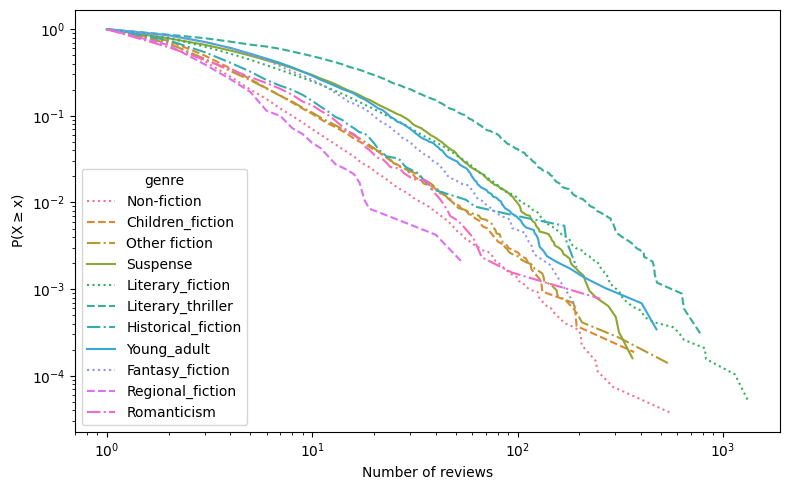

In [36]:
def set_linestyles(ax, lss):
    handles = ax.legend_.legend_handles
    lss_list = lss * int(np.ceil(len(ax.lines) / len(lss)))

    for line, ls, handle in zip(ax.lines, lss_list, handles):
        line.set_linestyle(ls)
        handle.set_ls(ls)
    return None


genre_num_review_prob = pd.concat([genre_cdf[genre] for genre in genres])

ax = sns.lineplot(data=genre_num_review_prob, x='num_reviews', y='probs', hue='genre', hue_order=genres)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews')
ax.set_ylabel('P(X$\geq$x)')

lss = [':', '--', '-.', '-']

set_linestyles(ax, lss)
ax.figure.set_size_inches(8, 5)
ax.figure.tight_layout()
ax.figure.savefig('../images/genre_num_review_cdf.png', dpi=150)

### The number of works and reviews per genre

In [40]:
reviewed_genre_freq = (book_metadata_reviews[['work_id', 'nur_genre']]
                       .drop_duplicates()
                       .nur_genre.value_counts()).rename('reviewed_books')
reviewed_genre_freq

Non-fiction           26844
Literary_fiction      19245
Other fiction          7253
Suspense               6281
Children_fiction       5329
Literary_thriller      3370
Young_adult            2910
Fantasy_fiction        1573
Romanticism            1288
Historical_fiction      557
Regional_fiction        472
Name: reviewed_books, dtype: int64

In [41]:
genre_review_freq = (book_metadata_reviews.nur_genre.value_counts()).rename('reviews')
genre_review_freq

Literary_fiction      201094
Non-fiction           108892
Literary_thriller      77061
Suspense               68565
Other fiction          37416
Young_adult            30263
Children_fiction       27461
Fantasy_fiction        13762
Romanticism             6428
Historical_fiction      3468
Regional_fiction        1528
Name: reviews, dtype: int64

In [42]:
genre_reviews_per_book = (genre_review_freq / reviewed_genre_freq).rename('reviews_per_book')
genre_reviews_per_book

Children_fiction       5.153124
Fantasy_fiction        8.748887
Historical_fiction     6.226212
Literary_fiction      10.449156
Literary_thriller     22.866766
Non-fiction            4.056474
Other fiction          5.158693
Regional_fiction       3.237288
Romanticism            4.990683
Suspense              10.916255
Young_adult           10.399656
Name: reviews_per_book, dtype: float64

In [43]:
genre_review_stats = pd.concat([reviewed_genre_freq, genre_review_freq, genre_reviews_per_book], axis=1)
print(genre_review_stats.loc[genre_order].to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  reviewed\_books &  reviews &  reviews\_per\_book \\
\midrule
Literary\_fiction   &           19245 &   201094 &         10.449156 \\
Literary\_thriller  &            3370 &    77061 &         22.866766 \\
Young\_adult        &            2910 &    30263 &         10.399656 \\
Children\_fiction   &            5329 &    27461 &          5.153124 \\
Suspense           &            6281 &    68565 &         10.916255 \\
Fantasy\_fiction    &            1573 &    13762 &          8.748887 \\
Romanticism        &            1288 &     6428 &          4.990683 \\
Historical\_fiction &             557 &     3468 &          6.226212 \\
Regional\_fiction   &             472 &     1528 &          3.237288 \\
Other fiction      &            7253 &    37416 &          5.158693 \\
Non-fiction        &           26844 &   108892 &          4.056474 \\
\bottomrule
\end{tabular}



/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_27039/273200625.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(genre_review_stats.loc[genre_order].to_latex())


## Impact stats

In [44]:
work_genre_impact = pd.merge(book_metadata_reviews[['work_id', 'review_id', 'nur_genre']].drop_duplicates(), impact, on='review_id', how='inner')
work_genre_impact.head(2)

,work_id,review_id,nur_genre,sentence_index,sentence,affect,style,narrative,reflection,match_index,impact_term_type,match_lemma,impact_type,match_word,impact_term,condition_match_index,condition_match_lemma,condition_match_word,condition_type,condition_term
0,impfic-work-1,impfic-review-429082,Non-fiction,1,Het was heel herkenbaar in diverse opzichten.,1,0,1,0,3,term,herkenbaar,Narrative,herkenbaar,herkenbaar,None,None,None,None,None
1,impfic-work-1,impfic-review-429082,Non-fiction,2,Het lijkt wel of dit boek aan kop staat ten op...,0,0,0,1,17,term,thema,Reflection,thema,thema,None,None,None,None,None


In [46]:
impact_cols = ['affect', 'style', 'narrative', 'reflection']
impact[impact_cols].sum()

affect        2142087
style          690981
narrative      705703
reflection     281717
dtype: int64

In [47]:
work_genre_impact_aggr = work_genre_impact.groupby(['work_id', 'nur_genre', 'review_id'])[impact_cols].sum()
work_genre_impact_aggr.reset_index()

,work_id,nur_genre,review_id,affect,style,narrative,reflection
0,impfic-work-1,Non-fiction,impfic-review-429082,3,1,2,1
1,impfic-work-10,Non-fiction,impfic-review-360902,2,0,1,0
2,impfic-work-10,Non-fiction,impfic-review-533735,1,0,0,0
3,impfic-work-100,Literary_fiction,impfic-review-29950,1,1,0,3
4,impfic-work-100,Literary_fiction,impfic-review-517129,1,1,0,1
...,...,...,...,...,...,...,...
480015,impfic-work-9999,Non-fiction,impfic-review-550178,3,0,2,1
480016,impfic-work-99995,Suspense,impfic-review-112072,2,0,2,0
480017,impfic-work-99995,Suspense,impfic-review-497826,1,0,1,0
480018,impfic-work-99997,Other fiction,impfic-review-499251,1,0,0,0


In [49]:
work_genre_impact_aggr = pd.merge(book_metadata_reviews[['work_id', 'nur_genre', 'review_id']], work_genre_impact_aggr.reset_index(), on=['work_id', 'nur_genre', 'review_id'], how='left').fillna(0.0)
work_genre_impact_aggr.head(2)


,work_id,nur_genre,review_id,affect,style,narrative,reflection
0,impfic-work-1,Non-fiction,impfic-review-17573,0.0,0.0,0.0,0.0
1,impfic-work-1,Non-fiction,impfic-review-429082,3.0,1.0,2.0,1.0


In [50]:
work_genre_impact_aggr.shape

(670924, 7)

In [51]:
work_genre_impact_long = (work_genre_impact_aggr
                          .melt(id_vars=['work_id', 'nur_genre', 'review_id'], var_name='impact', value_name='freq'))
work_genre_impact_long.head(2)

,work_id,nur_genre,review_id,impact,freq
0,impfic-work-1,Non-fiction,impfic-review-17573,affect,0.0
1,impfic-work-1,Non-fiction,impfic-review-429082,affect,3.0


In [52]:
work_genre_impact_long.groupby(['nur_genre', 'impact']).freq.describe()

count      mean       std  min  25%  50%  \
nur_genre          impact                                                    
0.0                affect       94986.0  0.000000  0.000000  0.0  0.0  0.0   
                   narrative    94986.0  0.000000  0.000000  0.0  0.0  0.0   
                   reflection   94986.0  0.000000  0.000000  0.0  0.0  0.0   
                   style        94986.0  0.000000  0.000000  0.0  0.0  0.0   
Children_fiction   affect       27461.0  3.503951  3.693949  0.0  1.0  2.0   
                   narrative    27461.0  1.062197  1.605115  0.0  0.0  0.0   
                   reflection   27461.0  0.361094  0.840945  0.0  0.0  0.0   
                   style        27461.0  0.907177  1.503872  0.0  0.0  0.0   
Fantasy_fiction    affect       13762.0  3.840140  4.353355  0.0  1.0  2.0   
                   narrative    13762.0  1.382939  1.868738  0.0  0.0  1.0   
                   reflection   13762.0  0.428135  0.952144  0.0  0.0  0.0   
                   style        13762.0  1.067650  1.753836  0.0  0.0  0.0   
Historical_fiction affect        3468.0  3.643022  3.646717  0.0  1.0  3.0   
                   narrative     3468.0  1.183103  1.598666  0.0  0.0  1.0   
                   reflection    3468.0  0.437140  0.870849  0.0  0.0  0.0   
                   style         3468.0  1.381776  1.783374  0.0  0.0  1.0   
Literary_fiction   affect      201094.0  3.416835  3.674372  0.0  1.0  2.0   
                   narrative   201094.0  1.012288  1.440587  0.0  0.0  1.0   
                   reflection  201094.0  0.432827  0.935121  0.0  0.0  0.0   
                   style       201094.0  1.339791  1.920550  0.0  0.0  1.0   
Literary_thriller  affect       77061.0  3.714356  3.828016  0.0  1.0  3.0   
                   narrative    77061.0  1.689402  1.899461  0.0  0.0  1.0   
                   reflection   77061.0  0.365425  0.832989  0.0  0.0  0.0   
                   style        77061.0  0.889529  1.535549  0.0  0.0  0.0   
Non-fiction        affect      108892.0  2.054660  2.401615  0.0  0.0  1.0   
                   narrative   108892.0  0.362405  0.812287  0.0  0.0  0.0   
                   reflection  108892.0  0.419691  0.864202  0.0  0.0  0.0   
                   style       108892.0  0.740844  1.229841  0.0  0.0  0.0   
Other fiction      affect       37416.0  3.250053  3.655704  0.0  1.0  2.0   
                   narrative    37416.0  0.922734  1.462796  0.0  0.0  0.0   
                   reflection   37416.0  0.511439  1.001257  0.0  0.0  0.0   
                   style        37416.0  1.138818  1.691454  0.0  0.0  1.0   
Regional_fiction   affect        1528.0  3.123037  3.495049  0.0  1.0  2.0   
                   narrative     1528.0  0.928665  1.355390  0.0  0.0  0.0   
                   reflection    1528.0  0.317408  0.780852  0.0  0.0  0.0   
                   style         1528.0  1.106675  1.746099  0.0  0.0  1.0   
Romanticism        affect        6428.0  4.063939  4.531732  0.0  1.0  3.0   
                   narrative     6428.0  1.259023  1.754752  0.0  0.0  1.0   
                   reflection    6428.0  0.316428  0.744712  0.0  0.0  0.0   
                   style         6428.0  1.169104  1.776495  0.0  0.0  0.0   
Suspense           affect       68565.0  3.755240  3.944218  0.0  1.0  3.0   
                   narrative    68565.0  1.729045  1.993785  0.0  0.0  1.0   
                   reflection   68565.0  0.399490  0.897531  0.0  0.0  0.0   
                   style        68565.0  0.863020  1.496293  0.0  0.0  0.0   
Young_adult        affect       30263.0  4.482206  4.634261  0.0  1.0  3.0   
                   narrative    30263.0  1.632191  2.079884  0.0  0.0  1.0   
                   reflection   30263.0  0.566599  1.112226  0.0  0.0  0.0   
                   style        30263.0  1.172752  1.809831  0.0  0.0  0.0   

                               75%    max  
nur_genre          impact                  
0.0                affect      0.0    0.0  
 

## Mapping between NUR code, NUR label and Aggregated genre label

In [53]:
import json

from impfic_core.map.map_genre import NUR_MAPPINGS

nur_mapping_file = '../data/mappings/nur_map.json'

with open(nur_mapping_file, 'rt') as fh:
    nur_map = json.load(fh)

# ensure NUR codes are integers
nur_map = {int(nur): nur_map[nur] for nur in nur_map}

for nur in sorted(NUR_MAPPINGS):
    if nur not in nur_map:
        print(nur)
        continue
    print(f"{nur} & {nur_map[nur]: <30} & {NUR_MAPPINGS[nur]: <20} \\\\")

280 & Fictie kinder- en jeugdboeken algemeen & Children_fiction     \\
281 & Fictie 4 - 6 jaar              & Children_fiction     \\
282 & Fictie 7 - 9 jaar              & Children_fiction     \\
283 & Fictie 10 - 12 jaar            & Children_fiction     \\
284 & Fictie 13 - 15 jaar            & Young_adult          \\
285 & Fictie 15+                     & Young_adult          \\
300 & Literaire fictie algemeen      & Literary_fiction     \\
301 & Literaire roman, novelle       & Literary_fiction     \\
302 & Vertaalde literaire roman, novelle & Literary_fiction     \\
305 & Literaire thriller             & Literary_thriller    \\
312 & Pockets populaire fictie       & Literary_fiction     \\
313 & Pockets spanning               & Suspense             \\
330 & Spannende boeken algemeen      & Suspense             \\
331 & Detective                      & Suspense             \\
332 & Thriller                       & Suspense             \\
334 & Fantasy                        & Fant